# Step 1: Calibration of camera intrinsic values

In [1]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
from itertools import count

In [2]:
CAMERA_ID = 'david'
CHESSBOARD_SQUARE_LENGTH_MM = 1
CHESSBOARD_DIMENSIONS = (9,6)
CAPTURE_DEVICE = 0
EXTRINSIC_CALIBRATION_FRAME_COUNT = 120

## Chessboard calibration (intrisinc parameters)

In [3]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
sample_object_points = np.zeros((CHESSBOARD_DIMENSIONS[0] * CHESSBOARD_DIMENSIONS[1],3), np.float32)

# TODO: check if this is the correct way to adjust the sizes. Used this accordint to: https://stackoverflow.com/questions/37310210/camera-calibration-with-opencv-how-to-adjust-chessboard-square-size
sample_object_points[:,:2] = np.mgrid[0:CHESSBOARD_DIMENSIONS[0],0:CHESSBOARD_DIMENSIONS[1]].T.reshape(-1,2) * CHESSBOARD_SQUARE_LENGTH_MM

# Arrays to store object points and image points from all the images.
object_points = [] # 3d point in real world space
image_points = [] # 2d points in image plane.

images = glob.glob(f'data/calibration/{CAMERA_ID}/*.png')
print(f'Found {len(images)} calibration images')

for fname in images:
    image = cv2.imread(fname)
    grayscale_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grayscale_image, CHESSBOARD_DIMENSIONS, None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        object_points.append(sample_object_points)

        improved_corners = cv2.cornerSubPix(grayscale_image, corners, (11,11), (-1,-1), criteria)
        image_points.append(improved_corners)
    else:
        print(f'Could not find chessboard corners in image {fname}')


Found 19 calibration images
Could not find chessboard corners in image data/calibration/david/calibration_frame_2021-04-02 16:39:56.783532.png
Could not find chessboard corners in image data/calibration/david/calibration_frame_2021-04-02 16:39:36.784381.png
Could not find chessboard corners in image data/calibration/david/calibration_frame_2021-04-02 16:38:46.784388.png
Could not find chessboard corners in image data/calibration/david/calibration_frame_2021-04-02 16:39:41.783697.png


### Intrinsic Parameters

In [4]:
ret, intrinsic_matrix, distortion_coefs, rotation_vecs, translation_vecs = cv2.calibrateCamera(object_points, image_points, grayscale_image.shape[::-1],None,None)
print('Image Dimensions')
print(grayscale_image.shape)
print('Intrinsic Matrix')
print(intrinsic_matrix)
print('Distortion Coefficients')
print(distortion_coefs)
print('Rotation Vectors')
print(rotation_vecs)
print('Translation Vectors')
print(translation_vecs)

Image Dimensions
(480, 640)
Intrinsic Matrix
[[563.75694941   0.         332.16377812]
 [  0.         558.41974    215.14146941]
 [  0.           0.           1.        ]]
Distortion Coefficients
[[ 0.22044414 -0.71477838 -0.00554924 -0.00207883  0.98609808]]
Rotation Vectors
[array([[-0.01860486],
       [ 0.17610102],
       [-0.07497551]]), array([[0.11681047],
       [0.15346942],
       [1.69163244]]), array([[0.20858081],
       [0.09252583],
       [2.32986873]]), array([[0.166542  ],
       [0.12575134],
       [1.95168276]]), array([[0.24231219],
       [0.06742631],
       [2.60452293]]), array([[0.17773233],
       [0.09973117],
       [2.4501321 ]]), array([[0.29928722],
       [0.0226388 ],
       [3.11977239]]), array([[-0.32006937],
       [-0.03510258],
       [-3.10804777]]), array([[-0.11721898],
       [ 0.12362866],
       [-1.17105577]]), array([[-0.48183016],
       [-0.13182307],
       [-2.98426722]]), array([[-0.27082947],
       [-0.02717017],
       [-3.12071

### Intrinsic Reprojection Error

In [5]:
def calculate_reprojection_error(objpoints, imgpoints, rvecs, tvecs, imatrix, distortion):
    mean_error = 0
    for i in range(len(objpoints)):
        calculted_image_points, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], imatrix, distortion)
        error = cv2.norm(imgpoints[i], calculted_image_points, cv2.NORM_L2)/len(calculted_image_points)
        mean_error += error

    return mean_error/len(objpoints)

In [6]:
print(f'Reprojection error: {calculate_reprojection_error(object_points, image_points, rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)}')

Reprojection error: 0.0305571624980066


## Chessboard calibration (extrinsic parameters)

In [7]:
captureDevice = cv2.VideoCapture(CAPTURE_DEVICE)

'''
EXTRINSIC PARAMETERS
'''

# Arrays to store object points and image points from all the images.
object_points = [] # 3d point in real world space
image_points = [] # 2d points in image plane.

for _ in range(EXTRINSIC_CALIBRATION_FRAME_COUNT):
    ret, image = captureDevice.read()
    grayscale_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grayscale_image, CHESSBOARD_DIMENSIONS, None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        object_points.extend(list(sample_object_points))
        improved_corners = cv2.cornerSubPix(grayscale_image, corners, (11,11), (-1,-1), criteria)
        image_points.extend(list(improved_corners))
    else:
        print(f'Could not find chessboard corners in image')

object_points = np.float64(object_points)
image_points = np.float64(image_points)
print(object_points.shape)
print(image_points.shape)
  

(6480, 3)
(6480, 3)


In [8]:
ret, rotation_vecs, translation_vecs = cv2.solvePnP(object_points, image_points, intrinsic_matrix, distortion_coefs)

### Extrinsic Reprojection Error

In [11]:
mean_error = 0

for i in range(len(object_points)):
    calulated_image_points, _ = cv2.projectPoints(object_points[i], rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)
    print(image_points[i])
    print(calulated_image_points)
    error = cv2.norm(image_points[i],calulated_image_points, cv2.NORM_L2)/len(calulated_image_points)
    mean_error += error

print(f'Reprojection error: {mean_error/len(object_points)}')

[[231.40455627 257.34472656]]
[[[230.45685284 257.55651713]]]


error: OpenCV(4.5.1) /tmp/pip-req-build-ddpkm6fn/opencv/modules/core/src/norm.cpp:1095: error: (-2:Unspecified error) in function 'double cv::norm(cv::InputArray, cv::InputArray, int, cv::InputArray)'
> Input type mismatch (expected: '_src1.type() == _src2.type()'), where
>     '_src1.type()' is 6 (CV_64FC1)
> must be equal to
>     '_src2.type()' is 14 (CV_64FC2)


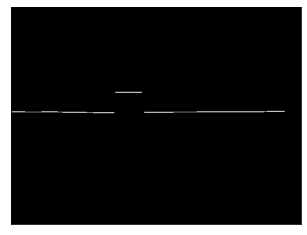

In [8]:
shadow_points = cv2.imread('data/result_234_256_4_7.png')
plt.xticks([]), plt.yticks([])
plt.imshow(shadow_points)

In [17]:
rotation_matrix = cv2.Rodrigues(rotation_vecs)[0]
extrinsic_matrix = np.concatenate((rotation_matrix, translation_vecs), axis=1)
perspective_projection_matrix = np.matmul(intrinsic_matrix, extrinsic_matrix)
perspective_projection_matrix

array([[ 6.02262763e+02, -2.24647092e+02,  1.22343461e+02,
         4.45062255e+03],
       [ 5.36799552e+01,  1.41161126e+02,  5.79059977e+02,
         6.42145501e+03],
       [ 1.32661284e-01, -8.18623724e-01,  5.58798875e-01,
         2.56916136e+01]])

In [10]:

def get_y_z_coord(i, j, ppm):
    k1 = ppm[2] * i
    k2 = ppm[2] * j
    k3 = k1 - ppm[0]
    k4 = k2 - ppm[1]
    print(k3)
    print(k3[1:3])
    a = [k3[1:3], k4[1:3]]
    b = [-k3[3], -k4[3]]

    res = np.linalg.solve(a, b)

    return (res[0], res[1])

In [11]:
get_y_z_coord(1,1, perspective_projection_matrix)

[ -575.75401672   146.95552139  -272.76864357 -2770.99315762]
[ 146.95552139 -272.76864357]


(4.122213924042929, -7.93790309913253)

In [12]:

points_x = []
points_y = []

for i in range(shadow_points.shape[0]):
    for j in range(shadow_points.shape[1]):

        if(shadow_points[i][j][0] == 255):
            x, y = get_y_z_coord(i,j, perspective_projection_matrix)
            points_x.append(x)
            points_y.append(y)

0912  584.70171377]
[ 91.61485117 -47.82670912]
[-563.00504246   91.61485117  -47.82670912  584.70171377]
[ 91.61485117 -47.82670912]
[-563.00504246   91.61485117  -47.82670912  584.70171377]
[ 91.61485117 -47.82670912]
[-563.00504246   91.61485117  -47.82670912  584.70171377]
[ 91.61485117 -47.82670912]
[-563.00504246   91.61485117  -47.82670912  584.70171377]
[ 91.61485117 -47.82670912]
[-563.00504246   91.61485117  -47.82670912  584.70171377]
[ 91.61485117 -47.82670912]
[-563.00504246   91.61485117  -47.82670912  584.70171377]
[ 91.61485117 -47.82670912]
[-562.95008998   91.3763138   -46.85713181  599.1659158 ]
[ 91.3763138  -46.85713181]
[-562.95008998   91.3763138   -46.85713181  599.1659158 ]
[ 91.3763138  -46.85713181]
[-562.95008998   91.3763138   -46.85713181  599.1659158 ]
[ 91.3763138  -46.85713181]
[-562.95008998   91.3763138   -46.85713181  599.1659158 ]
[ 91.3763138  -46.85713181]
[-562.95008998   91.3763138   -46.85713181  599.1659158 ]
[ 91.3763138  -46.85713181]
[-562.

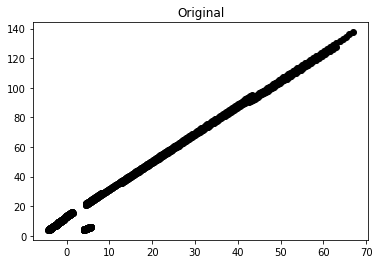

8, 4.159720818184367, 4.186243500723569, 4.212835178677292, 4.239496121620471, 4.266226600534238, 4.2930268878150875, 4.319897257284141, 4.346837984196468, 4.37384934525048, 4.400931618597413, 4.428085083850868, 4.455310022096439, 4.482606715901406, 4.509975449324517, 4.537416507925838, 4.564930178776686, 4.592516750469639, 4.620176513128627, 4.647909758419104, 4.675716779558291, 4.703597871325528, 4.731553330072668, 4.7595834537345985, 4.787688541839807, 4.815868895521067, 4.8441248175261755, 4.872456612228814, 4.900864585639461, 4.929349045416416, 4.95791030087691, 4.986548663008297, 5.015264444479341, 5.044057959651596, 5.072929524590884, 5.101879457078842, 5.130908076624605, 5.160015704476544, 5.189202663634119, 5.218469278859831, 5.247815876691263, 5.277242785453229, 5.306750335270014, 5.336338858077722, 5.366008687636719, 5.395760159544189, 5.425593611246778, 5.455509382053364, 5.485507813147907, 5.515589247602435, 5.545754030390108, 5.576002508398409, 5.606335030442452, 5.636751

In [13]:
figure, subplots = plt.subplots(1)
points = []
subplots.set_title('Original')
subplots.scatter(points_x, points_y, color='black')
plt.show()
print(points_x)